# Plotting Stoix Results
This notebook provides the code to perform the statistical tests and plotting recommended by Rliable. This code expects the JSON files outputted by the Stoix JSON Logger. 


### 1. Import the necessary modules
Import the necessary modules that will be used for processing the RL experiment data and for producing plots

In [29]:
import json

from marl_eval.plotting_tools.plotting import (
    aggregate_scores,
    performance_profiles,
    plot_single_task,
    probability_of_improvement,
    sample_efficiency_curves,
)

from marl_eval.utils.data_processing_utils import (
    create_matrices_for_rliable,
    data_process_pipeline,
)
from marl_eval.utils.diagnose_data_errors import (
    DiagnoseData
)

import collections
import json
from os import walk
from pathlib import Path
from typing import Any, Dict, List, Optional
import matplotlib.pyplot as plt

### 2. Create JSON file utility functions
We create simple functions to find all JSON experiment files in a directory and merge them all together into a single dict. If you desire, you can also save the merged final dictionary to a new JSON for later use instead of storing all JSON files separately.

In [30]:
def get_raw_dict_from_multirun_folder(
    multirun_folder: str,
) -> Dict[str, Any]:
    """Load all json files in a folder and merge them into a single dictionary."""
   
    return load_and_merge_json_dicts(
        _get_json_files_from_multirun(multirun_folder)
    )


def _get_json_files_from_multirun(multirun_folder: str) -> List[str]:
    """Get all json files in a folder and its subfolders."""
    files = []
    for dirpath, _, filenames in walk(multirun_folder):
        for file_name in filenames:
            if file_name.endswith(".json"):
                files.append(str(Path(dirpath) / Path(file_name)))
    print(f"Found {len(files)} json files in {multirun_folder}")
    return files


def update_dict(d: Dict[str, Any], u: Dict[str, Any]) -> Dict[str, Any]:
    """Recursively update a dictionary with another dictionary."""
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update_dict(d.get(k, {}), v)  # type: ignore
        else:
            d[k] = v
    return d


def load_and_merge_json_dicts(
    json_input_files: List[str], json_output_file: Optional[str] = None
) -> Dict:
    """Load and merge multiple json files into a single dictionary."""

    dicts = []
    json_input_files.sort()
    for file in json_input_files:
        with open(file, "r") as f:
            dicts.append(json.load(f))
    full_dict: Dict[str, Any] = {}
    for single_dict in dicts:
        update_dict(full_dict, single_dict)

    if json_output_file is not None:
        with open(json_output_file, "w+") as f:
            json.dump(full_dict, f, indent=4)

    return full_dict


def read_json_file(file_path: str) -> Any:
    """Read a json file."""
    with open(file_path, "r") as f:
        return json.load(f)

### 3. Specify the folder directory of all your JSON experiment results
Insert the folder directory of the results as well as which specific environment suite you want to plot. We specify the environment suite (not task) as its possible you are storing all results in the same folder. An example of an environment suite is "Atari" where a task is "Breakout". Another example is "Brax" where a task is "Ant". 

In [31]:
RESULTS_FOLDER_DIR = "./results" # Path to the folder containing the results - absolute path might be needed
ENVIRONMENT_SUITE = "gymnax" # e.g. "brax" or "gymnax"

### 4. Load and process the JSON files

As long as everything is valid (except the metrics dont need to be perfectly valid in the diagnosis if the overlapping metrics contain "mean_episode_return") then all plotting should work.

In [32]:
# Import the data
raw_dict = get_raw_dict_from_multirun_folder(
        multirun_folder=RESULTS_FOLDER_DIR,
    )

# Choose the list of metrics to normalize
METRICS_TO_NORMALIZE = ["mean_episode_return"]

# Call data_process_pipeline to normalize the chosen metrics and to clean the data
print(DiagnoseData(raw_dict).check_data())
processed_data = data_process_pipeline(
    raw_data=raw_dict, metrics_to_normalize=METRICS_TO_NORMALIZE
)

# Create a custom legend mapping dictionary for the plotting functions
# This dictionary maps the algorithm names in the data to the names that will be displayed in the plots
LEGEND_MAP = None # e.g. {"ff_ppo" : "PPO", "ff_mpo" : "MPO"}

Found 18 json files in ./results
The metrics used across the different steps, runs, algorithms                    and scenarios are not the same
                    The overlapping metrics are :
 ['mean_episode_return', 'steps_per_second']
invalid format for the environment gymnax!
{'gymnax': {'valid_algorithms': True, 'valid_algorithm_names': True, 'valid_runs': True, 'valid_steps': True, 'valid_metrics': False}}


Next we need to create two different dictionaries that will be used to create plots. To do this we will make use of the [`create_matrices_for_rliable`](https://github.com/instadeepai/marl-eval/blob/4856b06467872fd8b6f8a5db5fa7c9d7d55e2431/marl_eval/utils/data_processing_utils.py#L279) function. 
  
  **a)  metric_dictionary_return:**

  - The dictionary will have the names of all aggregated metrics as keys. Under each aggregated metric key there will be a 2D array corresponding to the mean of the normalised absolute metric values for each algorithm in a given experiment. 

  - These 2D arrays will have dimensions given as (number of runs x number of tasks). 

  **b)  final_metric_tensor_dictionary:**

  - This dictionary will, similarly, have keys corresponding to the aggregated experiment metrics. Under each aggregated metric key there will now be a 3D array corresponding to the mean normalised metric at each evaluation step. 

  - These 3D arrays will have dimensions given as (number of runs x number of tasks x number of logging steps).

The `create_matrices_for_rliable` function has 3 arguments which are:

  - data_dictionary: The dictionary of processed data
  
  - environment_name: Name of environment for which the arrays should be computed.

  - metrics_to_normalize: List of metric metric names that should be normalised.

In [33]:
environment_comparison_matrix, sample_efficiency_matrix = create_matrices_for_rliable(
    data_dictionary=processed_data,
    environment_name=ENVIRONMENT_SUITE,
    metrics_to_normalize=METRICS_TO_NORMALIZE,
)

### 5. Produce the Plots:
1. Performance Profiles
2. Aggregate Point Scores
3. Sample Efficiency
4. Probability of Improvement
5. Individual Task Plots

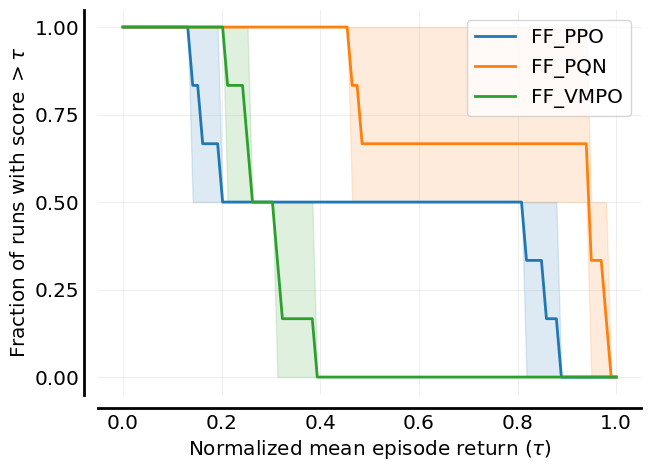

In [34]:
fig = performance_profiles(
    environment_comparison_matrix,
    metric_name="mean_episode_return",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
    legend_map=LEGEND_MAP,
)

The tabular results are stored in ./aggregated_score_mean_episode_return.csv and they are the following
                            FF_PPO             FF_PQN            FF_VMPO
Median          0.51 [0.48, 0.53]   0.8 [0.71, 0.96]  0.29 [0.27, 0.31]
IQM              0.5 [0.48, 0.53]  0.84 [0.71, 0.97]  0.28 [0.26, 0.32]
Mean            0.51 [0.48, 0.53]   0.8 [0.71, 0.96]  0.29 [0.27, 0.31]
Optimality Gap  0.49 [0.47, 0.52]   0.2 [0.04, 0.29]  0.71 [0.69, 0.73]


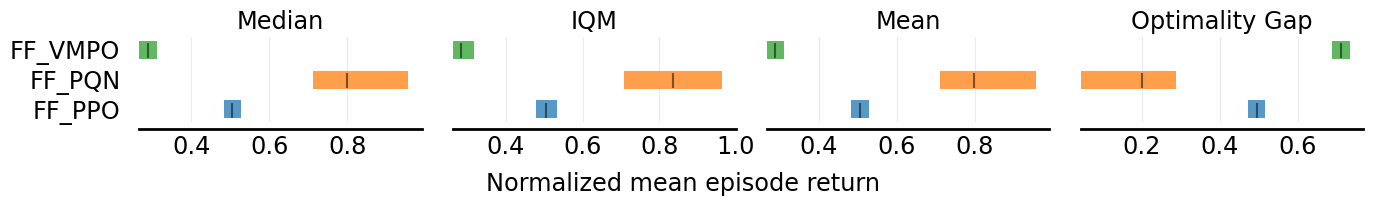

In [35]:
fig, _, _ = aggregate_scores(
    dictionary=environment_comparison_matrix,
    metric_name="mean_episode_return",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
    save_tabular_as_latex=False,
    legend_map=LEGEND_MAP,
)

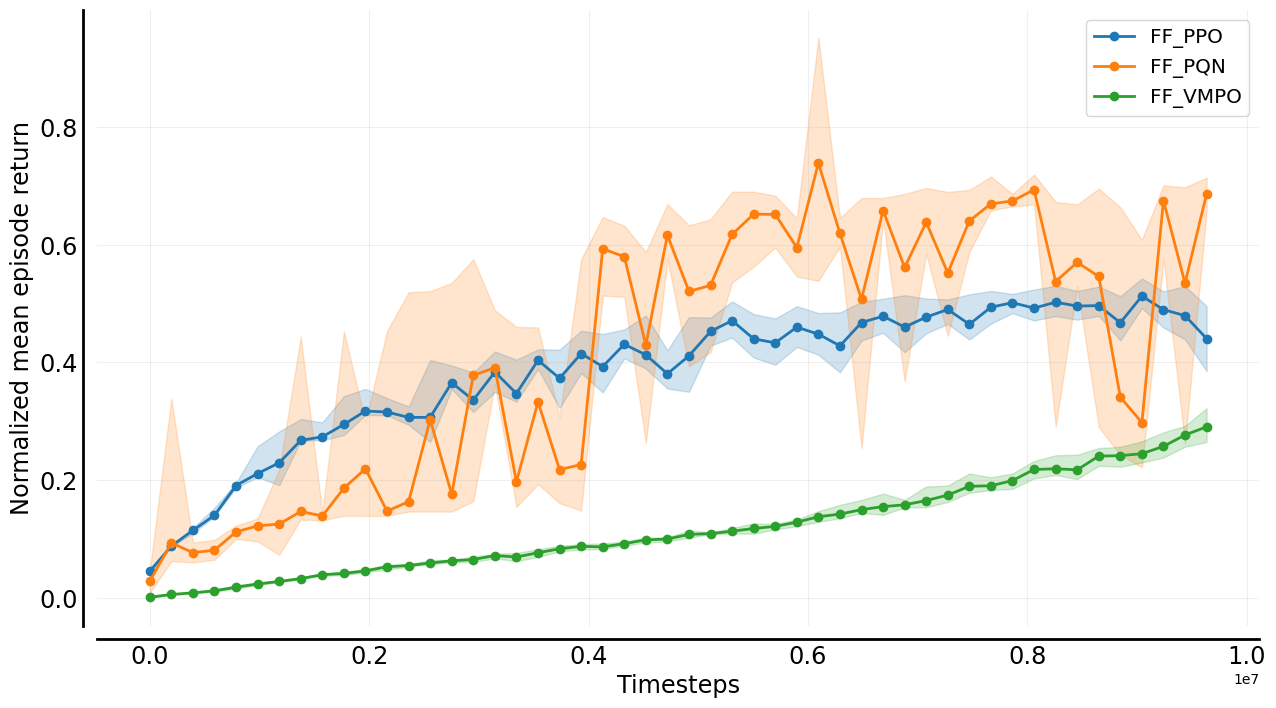

In [36]:
fig, _, _ = sample_efficiency_curves(
    dictionary=sample_efficiency_matrix,
    metric_name="mean_episode_return",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
    legend_map=LEGEND_MAP,
)

(-0.1, 1.1)

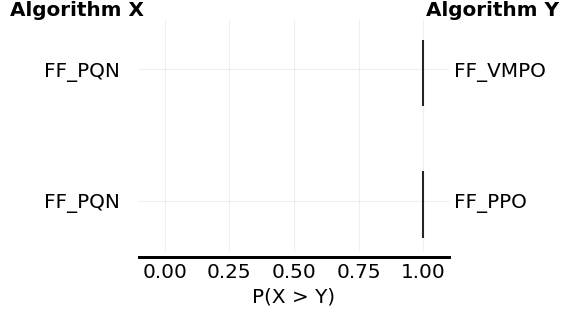

In [37]:
ALGORITHM_TO_COMPARE = "ff_pqn" # e.g. "ff_ppo"
found_algorithm_names = [algo.lower() for algo in environment_comparison_matrix["mean_norm_mean_episode_return"].keys()]
found_algorithm_names.remove(ALGORITHM_TO_COMPARE)
algorithms_to_compare = [[ALGORITHM_TO_COMPARE] + [algorithm_name] for algorithm_name in found_algorithm_names]

fig = probability_of_improvement(
    environment_comparison_matrix,
    metric_name="mean_episode_return",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
    algorithms_to_compare=algorithms_to_compare,
    legend_map=LEGEND_MAP,
)
plt.gca().set_xlim([-0.1, 1.1])

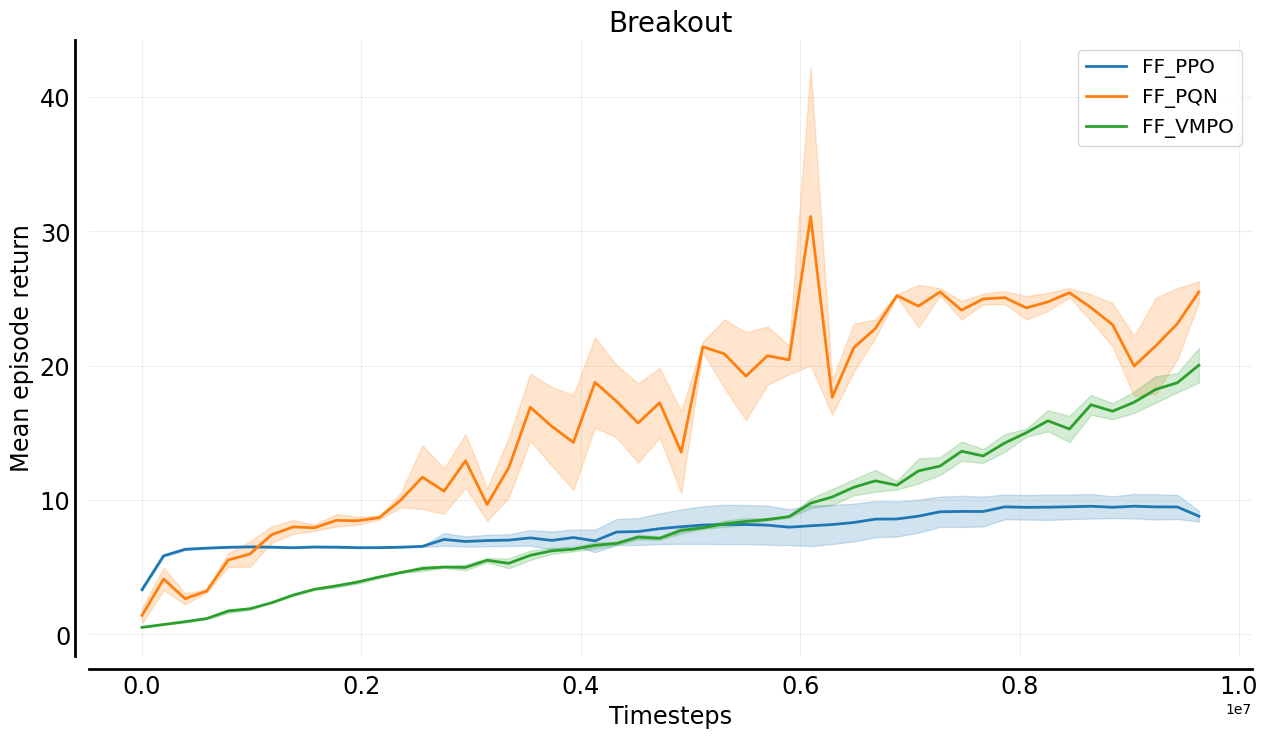

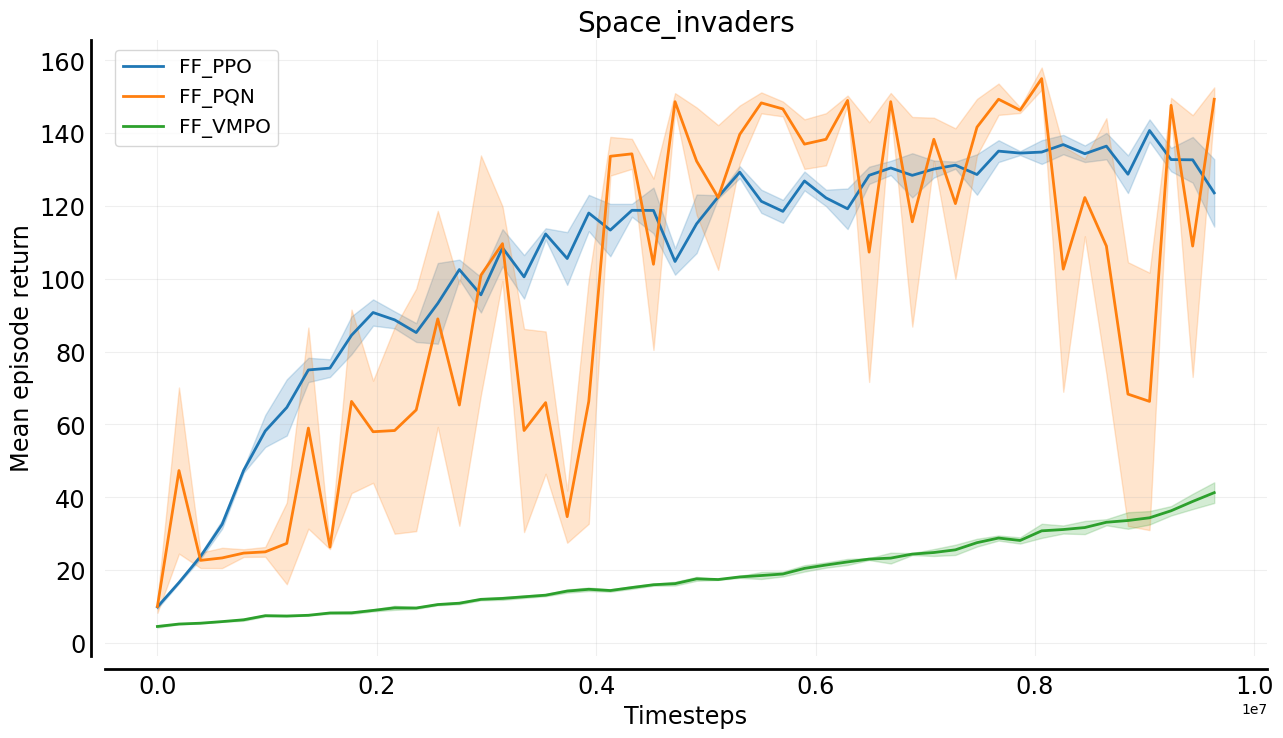

In [38]:
for task in processed_data[ENVIRONMENT_SUITE]:
    fig = plot_single_task(
        processed_data=processed_data,
        environment_name=ENVIRONMENT_SUITE,
        task_name=task,
        metric_name="mean_episode_return",
        metrics_to_normalize=[], # Put in METRICS_TO_NORMALIZE if you want the normalised scores per task,
        legend_map=LEGEND_MAP,
    )
    plt.title(f"{task.capitalize()}", fontsize=20)